In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

In [3]:
# this pre-processing code of the KDD dataset is adapter from https://github.com/lironber/GOAD/blob/master/data_loader.py

df_colnames = pd.read_csv(urls[1], skiprows=1, sep=':', names=['f_names', 'f_types'])
df_colnames.loc[df_colnames.shape[0]] = ['status', ' symbolic.']

df = pd.read_csv(urls[0], header=None, names=df_colnames['f_names'].values)
df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')]
df_continuous = df_colnames[df_colnames['f_types'].str.contains('continuous.')]
samples = pd.get_dummies(df.iloc[:, :-1], columns=df_symbolic['f_names'][:-1])

labels = np.where(df['status'] == 'normal.', 1, 0)

### Clearn-up Dataset

In [4]:
cols = df.columns.to_list()

cols.remove('status')

#
# columns which value is fixed
#
def is_fixed(c):
    return len(df[c].unique()) <= 1

col_fixed = [s for s in cols if is_fixed(s)]

# remove columns
for s in col_fixed:
    cols.remove(s)

#
# columns which type is string
#
col_str = [s for s in cols if df[s].dtype == np.dtype('object')]
df_str = df[col_str]
df_str = pd.get_dummies(df_str)

# remove columns
for s in col_str:
    cols.remove(s)

#
# columns which type is binary
#
def is_binary(c):
    u = df[c].unique()
    return len(u) == 2 and u[0] == 0 and u[1] == 1

col_binary = [s for s in cols if is_binary(s)]
df_binary = df[col_binary]

# remove columns
for s in col_binary:
    cols.remove(s)

df_numerical = df[cols]

In [5]:
print(col_fixed, col_str, sep='\n')

['num_outbound_cmds', 'is_host_login']
['protocol_type', 'service', 'flag']


In [6]:
scaler = MinMaxScaler()
df_num = scaler.fit_transform(df_numerical)
df_scaled = np.hstack([df_num, df_str.values, df_binary.values])

### Build train/test sets

In [7]:
norm_samples = df_scaled[labels == 1]  # normal data
attack_samples = df_scaled[labels == 0]  # attack data

norm_labels = labels[labels == 1]
attack_labels = labels[labels == 0]

In [8]:
norm_samples.shape, attack_samples.shape

((97278, 116), (396743, 116))

In [9]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
# X_test_attack = attack_samples[:len_attack_test]
rows = np.array(attack_samples.shape[0])
X_test_attack = attack_samples[np.random.choice(rows, len_attack_test)]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [10]:
X_train.shape

(77822, 116)

In [11]:
X_test.shape

(38912, 116)

In [12]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [13]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [57]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = original_dim // 2
latent_dim = original_dim // 4

print(original_dim, input_shape, intermediate_dim, latent_dim)

116 (116,) 58 29


In [58]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 116)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 58)           6786        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 29)           1711        ['dense_7[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 29)           1711        ['dense_7[0][0]']                
                                                                                            

In [59]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='relu')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 29)]              0         
                                                                 
 dense_8 (Dense)             (None, 58)                1740      
                                                                 
 dense_9 (Dense)             (None, 116)               6844      
                                                                 
Total params: 8,584
Trainable params: 8,584
Non-trainable params: 0
_________________________________________________________________


In [60]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [61]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

vae_model.compile(optimizer=opt, loss=vae_loss, metrics=['accuracy'])
vae_model.summary(expand_nested=True)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 116)]             0         
                                                                 
 encoder (Functional)        (None, 29)                10208     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| encoder_input (InputLayer)  [(None, 116)]           0         |
|                                                               |
| dense_7 (Dense)           (None, 58)                6786      |
|                                                               |
| z_mean (Dense)            (None, 29)                1711      |
|                                                               |
| z_log_var (Dense)         (None, 29)                1711      |
|                                                               |
| z (Lambda)                (None, 29)                0    

In [62]:
epochs = 50 # 32
batch_size = 256

# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=epochs,
                        batch_size=batch_size)

Train on 77822 samples
Epoch 1/50
77822/77822 [==============================] - 1s 8us/sample - loss: 2085.1177 - accuracy: 0.1251
Epoch 2/50
77822/77822 [==============================] - 1s 7us/sample - loss: 535.0578 - accuracy: 0.0935
Epoch 3/50
77822/77822 [==============================] - 1s 7us/sample - loss: 291.8805 - accuracy: 0.1337
Epoch 4/50
77822/77822 [==============================] - 1s 6us/sample - loss: 176.9352 - accuracy: 0.1635
Epoch 5/50
77822/77822 [==============================] - 1s 7us/sample - loss: 140.7726 - accuracy: 0.1848
Epoch 6/50
77822/77822 [==============================] - 1s 7us/sample - loss: 128.0299 - accuracy: 0.1772
Epoch 7/50
77822/77822 [==============================] - 1s 7us/sample - loss: 119.2655 - accuracy: 0.1704
Epoch 8/50
77822/77822 [==============================] - 1s 7us/sample - loss: 113.7861 - accuracy: 0.1693
Epoch 9/50
77822/77822 [==============================] - 1s 7us/sample - loss: 109.5380 - accuracy: 0.1714
Epoc

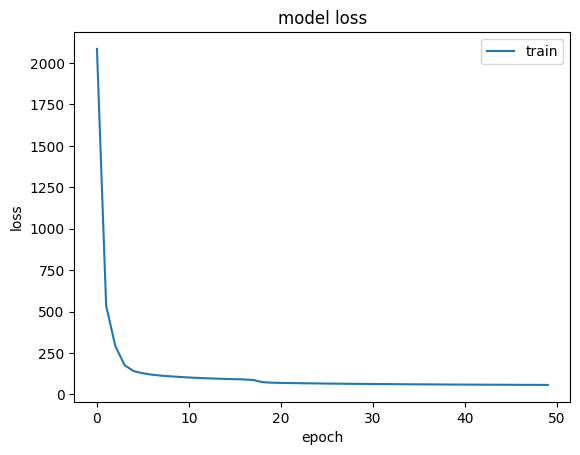

In [63]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [64]:
X_train_pred = vae_model.predict(X_train)

c:\study\py_projects\flappybird\env\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [65]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.004269398228128724
median error 0.002577141983715567
99Q: 0.021345479865968856
setting threshold on 0.021345479865968856 


In [66]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.5046001233552632

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     19456
         1.0       0.98      0.99      0.99     19456

    accuracy                           0.99     38912
   macro avg       0.99      0.99      0.99     38912
weighted avg       0.99      0.99      0.99     38912



In [68]:
X_pred.shape

(38912, 116)

In [69]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [70]:
mse_reconstruction(X_test, X_pred)

863.424141808884

In [28]:
X_encoded = encoder.predict(X_test)

c:\study\py_projects\flappybird\env\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
X_transform = pca.fit_transform(X_encoded)

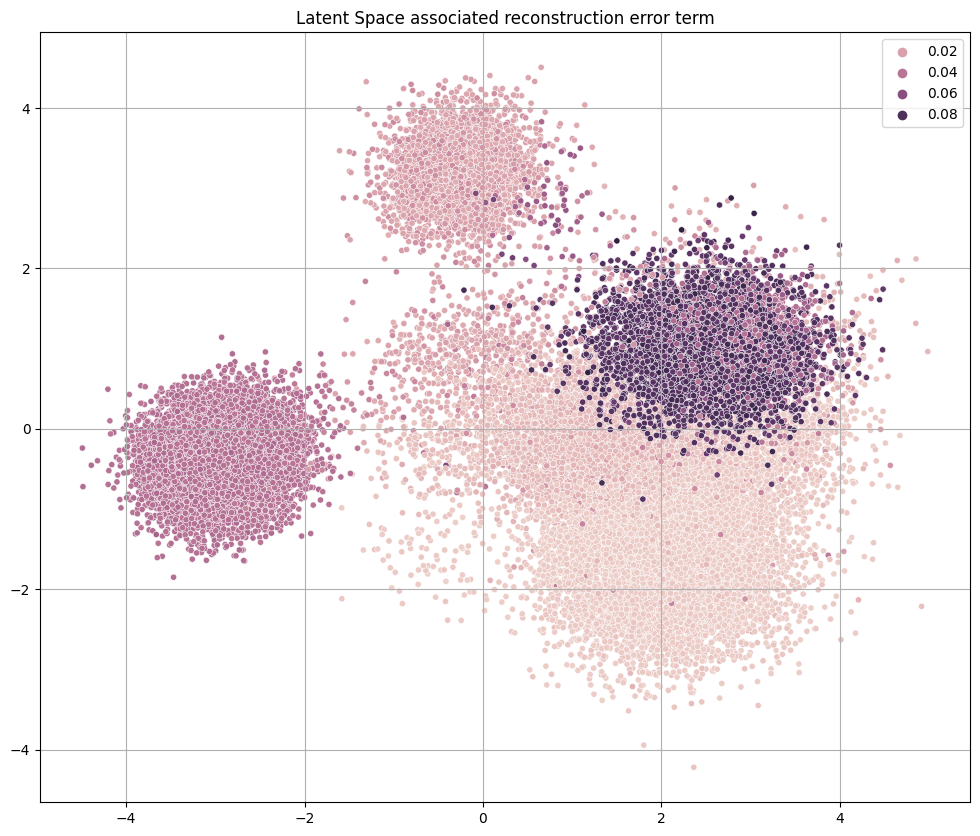

In [30]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.title("Latent Space associated reconstruction error term")
plt.grid()
plt.show()

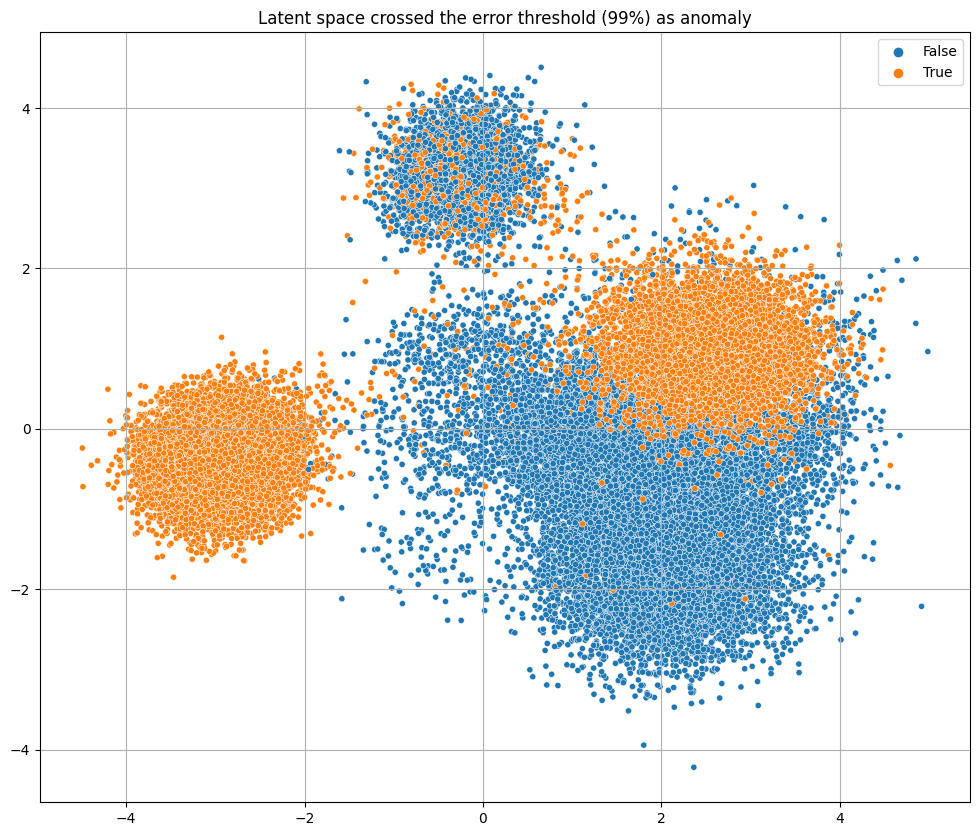

In [31]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.title("Latent space crossed the error threshold (99%) as anomaly")
plt.grid()
plt.show()

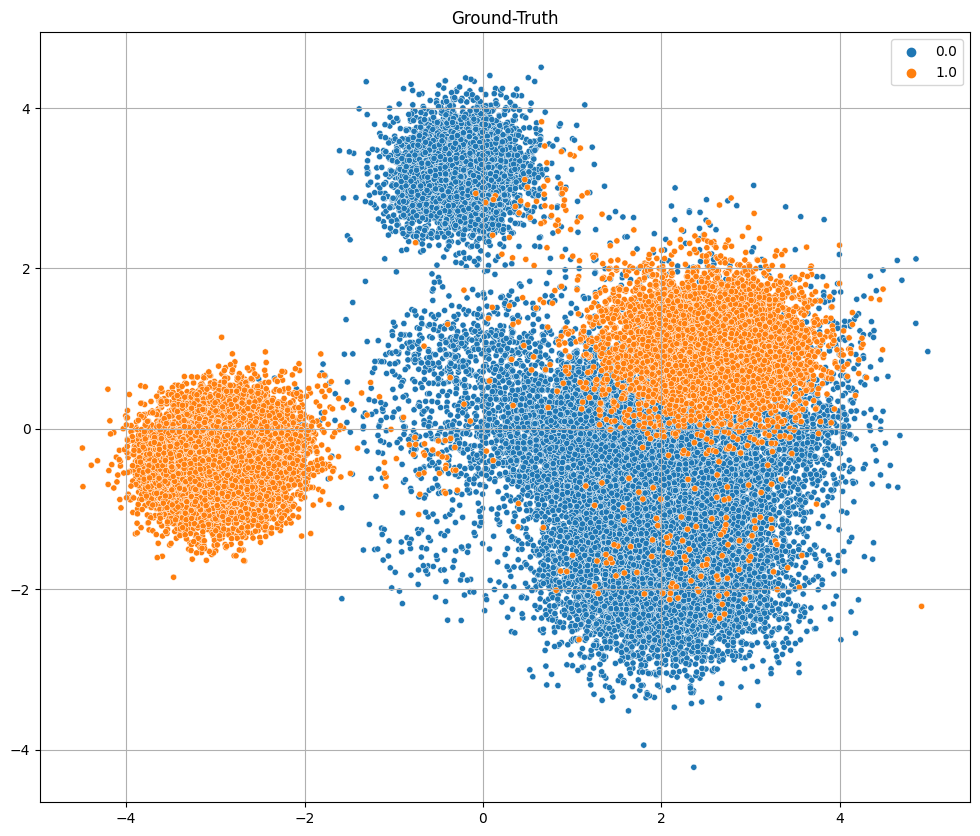

In [32]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=y_test)
plt.title("Ground-Truth")
plt.grid()
plt.show()

## Scores on Simpe AE

In [33]:
INPUT_DIM = X_train.shape[1]
ENCODING_DIM = INPUT_DIM // 4

# Encoder model
inputs = Input(shape=(INPUT_DIM,), name="input") 
encoded = Dense(ENCODING_DIM, activation="sigmoid", name="encoder_out")(inputs)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='decoder_in')
reconstruction = Dense(INPUT_DIM, activation="sigmoid", name="reconstruction")(encoded_inputs)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
simple_ae_model = Model(inputs, outputs, name='simple_ae')

simple_ae_model.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

In [34]:
simple_ae_model.summary(expand_nested=True)

Model: "simple_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 116)]             0         
                                                                 
 encoder (Functional)        (None, 29)                3393      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input (InputLayer)        [(None, 116)]             0         |
|                                                               |
| encoder_out (Dense)       (None, 29)                3393      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder (Functional)        (None, 116)               3480      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| decoder_in (InputLayer)   [(None, 29)]              0         |
|                                                               |
| reconstruction (Dense)    (None, 116)               348

In [35]:
epochs = 32
batch_size = 256

history = simple_ae_model.fit(X_train, X_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Train on 77822 samples
Epoch 1/32
77822/77822 [==============================] - 1s 7us/sample - loss: 0.1763 - accuracy: 0.9053
Epoch 2/32
77822/77822 [==============================] - 1s 7us/sample - loss: 0.0488 - accuracy: 0.9267
Epoch 3/32
77822/77822 [==============================] - 1s 7us/sample - loss: 0.0314 - accuracy: 0.9332
Epoch 4/32
77822/77822 [==============================] - 1s 7us/sample - loss: 0.0231 - accuracy: 0.9353
Epoch 5/32
77822/77822 [==============================] - 1s 7us/sample - loss: 0.0188 - accuracy: 0.9366
Epoch 6/32
77822/77822 [==============================] - 1s 8us/sample - loss: 0.0161 - accuracy: 0.9371
Epoch 7/32
77822/77822 [==============================] - 1s 7us/sample - loss: 0.0144 - accuracy: 0.9374
Epoch 8/32
77822/77822 [==============================] - 1s 7us/sample - loss: 0.0134 - accuracy: 0.9375
Epoch 9/32
77822/77822 [==============================] - 0s 6us/sample - loss: 0.0128 - accuracy: 0.9375
Epoch 10/32
77822/77822

In [36]:
X_train_pred = simple_ae_model.predict(X_train)
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

X_pred = simple_ae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

print("Detect anomaly (%) :", np.count_nonzero(anomalies) / len(anomalies))
print(classification_report(y_test, anomalies))

c:\study\py_projects\flappybird\env\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Avg error 0.0012743052313068598
median error 0.0008817131167992701
99Q: 0.007013418331268075
setting threshold on 0.007013418331268075 
Detect anomaly (%) : 0.5042403371710527
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     19456
         1.0       0.98      0.99      0.99     19456

    accuracy                           0.99     38912
   macro avg       0.99      0.99      0.99     38912
weighted avg       0.99      0.99      0.99     38912



In [37]:
mse_reconstruction(X_test, X_pred)

680.9891727893836

## Deeper AE

In [49]:
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = INPUT_DIM // 2
ENCODING_DIM = INPUT_DIM // 4

# Encoder model
inputs = Input(shape=(INPUT_DIM,), name="input") 
hidden_encoder = Dense(HIDDEN_DIM, activation="relu", name="hidden-1")(inputs)
encoded = Dense(ENCODING_DIM, activation="relu", name="encoder_out")(hidden_encoder)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='decoder_in')
hidden_decoder = Dense(HIDDEN_DIM, activation="relu", name="hidden-2")(encoded_inputs)
reconstruction = Dense(INPUT_DIM, activation="sigmoid", name="decoder_out")(hidden_decoder)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
deeper_ae = Model(inputs, outputs, name='deeper_ae')

deeper_ae.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

In [50]:
deeper_ae.summary(expand_nested=True)

Model: "deeper_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 116)]             0         
                                                                 
 encoder (Functional)        (None, 29)                8497      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input (InputLayer)        [(None, 116)]             0         |
|                                                               |
| hidden-1 (Dense)          (None, 58)                6786      |
|                                                               |
| encoder_out (Dense)       (None, 29)                1711      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder (Functional)        (None, 116)               8584      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| decoder_in (InputLayer)   [(None, 29)]              0  

In [40]:
epochs = 32
batch_size = 256

history = deeper_ae.fit(X_train, X_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Train on 77822 samples
Epoch 1/32
77822/77822 [==============================] - 1s 8us/sample - loss: 0.0667 - accuracy: 0.9235
Epoch 2/32
77822/77822 [==============================] - 1s 8us/sample - loss: 0.0145 - accuracy: 0.9373
Epoch 3/32
77822/77822 [==============================] - 1s 8us/sample - loss: 0.0127 - accuracy: 0.9376
Epoch 4/32
77822/77822 [==============================] - 1s 8us/sample - loss: 0.0121 - accuracy: 0.9377
Epoch 5/32
77822/77822 [==============================] - 1s 9us/sample - loss: 0.0117 - accuracy: 0.9377
Epoch 6/32
77822/77822 [==============================] - 1s 9us/sample - loss: 0.0115 - accuracy: 0.9377
Epoch 7/32
77822/77822 [==============================] - 1s 8us/sample - loss: 0.0113 - accuracy: 0.9377
Epoch 8/32
77822/77822 [==============================] - 1s 8us/sample - loss: 0.0111 - accuracy: 0.9377
Epoch 9/32
77822/77822 [==============================] - 1s 8us/sample - loss: 0.0110 - accuracy: 0.9377
Epoch 10/32
77822/77822

In [41]:
X_train_pred = deeper_ae.predict(X_train)
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

X_pred = deeper_ae.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

print("Detect anomaly (%) :", np.count_nonzero(anomalies) / len(anomalies))
print(classification_report(y_test, anomalies))

c:\study\py_projects\flappybird\env\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Avg error 0.0008744426635582042
median error 0.0005733386220732235
99Q: 0.004137822557094518
setting threshold on 0.004137822557094518 
Detect anomaly (%) : 0.5048314144736842
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     19456
         1.0       0.98      0.99      0.99     19456

    accuracy                           0.99     38912
   macro avg       0.99      0.99      0.99     38912
weighted avg       0.99      0.99      0.99     38912



In [42]:
mse_reconstruction(X_test, X_pred)

360.75771501828126

## Scores on PCA

In [43]:
def try_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)
    
    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data)

In [44]:
pca_full, mnist_data_full = try_pca(X_train, X_train.shape[1])

Variance explained with 116 components: 1.0


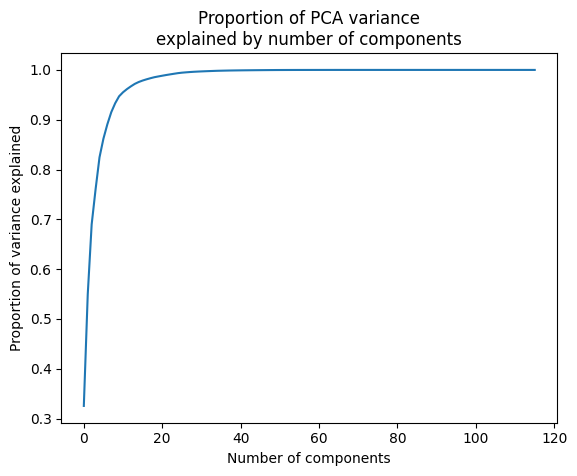

In [45]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained");

In [46]:
pca_2, pca_data_2 = try_pca(X_train, 2)

Variance explained with 2 components: 0.55


In [47]:
pca_8, pca_data_8 = try_pca(X_train, 8)

x = pca_8.transform(X_test)
x = pca_8.inverse_transform(x)

Variance explained with 8 components: 0.92


In [48]:
mse_reconstruction(X_test, x)

981.7397491132998